# Extract emails

In [ ]:
import imaplib
import email

# Function to safely get email body
def get_email_body(msg):
    body = ""
    if msg.is_multipart():
        for part in msg.walk():
            if part.get_content_type() == "text/plain":
                charset = part.get_content_charset()
                payload = part.get_payload(decode=True)
                if payload:
                    try:
                        if charset:
                            body += payload.decode(charset, errors="replace")
                        else:
                            body += payload.decode(errors="replace")
                    except Exception:
                        body += payload.decode('utf-8', errors="replace")
    else:
        payload = msg.get_payload(decode=True)
        if payload:
            charset = msg.get_content_charset()
            try:
                if charset:
                    body += payload.decode(charset, errors="replace")
                else:
                    body += payload.decode(errors="replace")
            except Exception:
                body += payload.decode('utf-8', errors="replace")
    return body

# Connect to an IMAP server
mail = imaplib.IMAP4_SSL("imap.gmail.com")
mail.login("cliffordojuka53@gmail.com", "YOUR_APP_PASSWORD_HERE")
mail.select("inbox")

# Search and fetch email UIDs
status, messages = mail.search(None, "ALL")
email_uids = messages[0].split()

emails = []
for uid in email_uids[:2000]:  # Limit to 2000 emails
    status, msg_data = mail.fetch(uid, "(RFC822)")
    msg = email.message_from_bytes(msg_data[0][1])
    
    # Extract subject and body text
    subject = msg["subject"]
    body = get_email_body(msg)
    emails.append(subject + " " + body)

mail.logout()

('BYE', [b'LOGOUT Requested'])

# Preprocessing email text

In [28]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_html(raw_html):
    if not isinstance(raw_html, str):
        return ""
    soup = BeautifulSoup(raw_html, "html.parser")
    return soup.get_text(separator=" ", strip=True)

def preprocess_text(text):
    text = clean_html(text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return " ".join(tokens)

cleaned_emails = [preprocess_text(email) for email in emails]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\USER\AppData\Local\Temp\ipykernel_3396\419012059.py:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(raw_html, "html.parser")


# Feature Extraction(TF-IDF)

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1,2), max_df=0.9, min_df=5)
X = vectorizer.fit_transform(cleaned_emails)

# Apply K-means

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

num_clusters = 10  # Tune based on dataset or use methods to determine

kmeans = KMeans(
    n_clusters=num_clusters, 
    init='k-means++',      # Better initialization
    n_init=10,             # Number of initializations for robustness
    max_iter=300,          # Max iterations per init
    random_state=42
)

kmeans.fit(X)

labels = kmeans.labels_
inertia = kmeans.inertia_

print(f"Within-cluster sum of squares (inertia): {inertia}")
print(f"Cluster counts: {dict(zip(*np.unique(labels, return_counts=True)))}")


Within-cluster sum of squares (inertia): 1685.9858609505911
Cluster counts: {0: 198, 1: 81, 2: 189, 3: 1413, 4: 119}


# Topic modeling with LDA(Gensim)

In [32]:
import gensim
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel

tokenized_emails = [email.split() for email in cleaned_emails]
dictionary = corpora.Dictionary(tokenized_emails)
corpus = [dictionary.doc2bow(text) for text in tokenized_emails]

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_clusters,
    random_state=42,
    passes=10
)

for idx in range(num_clusters):
    top_words = lda_model.show_topic(idx, topn=10)
    topic_keywords = [word for word, _ in top_words]
    print(f"Topic {idx}: {', '.join(topic_keywords)}")

Topic 0: linkedin, job, cfi, email, clifford, week, help, view, kenya, learn
Topic 1: read, important, min, data, width, science, python, height, email, comment
Topic 2: event, email, developer, africa, community, goal, talking, day, join, get
Topic 3: google, data, cloud, message, skill, email, view, new, africa, learning
Topic 4: question, read, answer, email, time, work, new, test, one, please


# Visualize Cluster with PCA

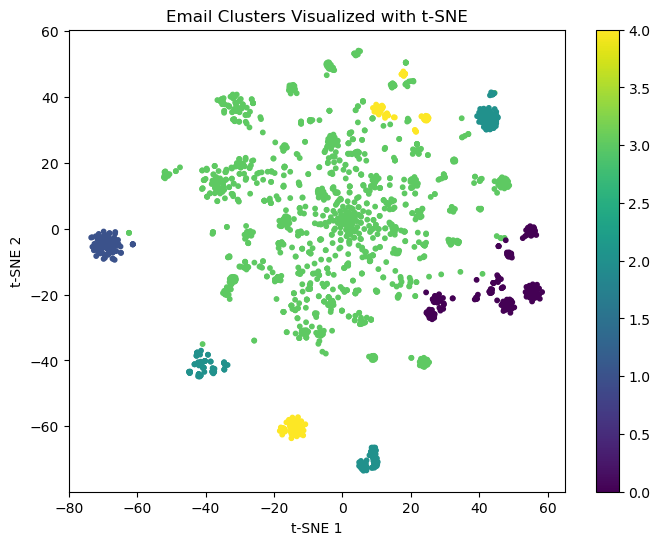

In [33]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, max_iter=2000, random_state=42)
tsne_results = tsne.fit_transform(X.toarray())

plt.figure(figsize=(8,6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', s=10)
plt.title('Email Clusters Visualized with t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar()
plt.show()